# Gesture Recognition Project

We are going to build following models will be able to predict the 5 gestures correctly:
1.   3D Conv model 
2.   CNN + RNN



#### importing libraries

In [1]:
import numpy as np
import random
import datetime
import os
import matplotlib.pyplot as plt

from skimage.io import imread
from skimage.transform import resize as imresize

import tensorflow as tf
from tensorflow import keras 

import warnings
warnings.filterwarnings("ignore")

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
random.seed(30)
tf.random.set_seed(30)

#### Reading data paths

Now We read training and Validation Data and setting batch size. Here, one thing is to be noted that we'll be going to increase batch size upto the level where GPU capacity is fully utilised

In [3]:
train_data_paths = np.random.permutation(open('/datasets/Project_data/train.csv').readlines())
val_data_paths = np.random.permutation(open('/datasets/Project_data/val.csv').readlines())

num_classes = 5

In [4]:
print('Train data size {}'.format(len(train_data_paths)))
print('Validation data size {}'.format(len(val_data_paths)))

Train data size 663
Validation data size 100


#### Image size in train & val data

In [5]:
import glob

train_data_path = os.path.join('/datasets/Project_data/train','*')
train_data_points = glob.glob(train_data_path)

imgs_x_dimns=[]
imgs_y_dimns=[]

for data_point in train_data_points:
  imgs_path_in_video = os.path.join(data_point,'*')
  for img in glob.glob(imgs_path_in_video):
    image = imread(img)
    x_dimn = image.shape[0]
    y_dimn = image.shape[1]

    if x_dimn not in imgs_x_dimns:
      imgs_x_dimns.append(x_dimn)
    if y_dimn not in imgs_y_dimns:
      imgs_y_dimns.append(y_dimn)  
print('imgs_x_dimns',imgs_x_dimns)
print('imgs_y_dimns',imgs_y_dimns)

imgs_x_dimns [360, 120]
imgs_y_dimns [360, 160]


## Generator
This is one of the most important part of the code. In the generator, we are going to preprocess image as we have images of 2 different dimns as well as create a batch of video frames. We have to experminet with `img_idx`, `y`,`z` and normalization such that we get high accuracy

In [5]:
def data_generator(source_path, data_list, batch_size, imgs_to_feed_in_one_data_pnt, img_width =100,img_height= 100, augment=False):
    # Custom set of images out of 30 images - Say: img_idx=[5,6,...,24,25]. Why?? - Bcoz some of the images are not useful
    start_img = 15 - int(imgs_to_feed_in_one_data_pnt/2)   
    end_img = 15 + int(imgs_to_feed_in_one_data_pnt/2)
    img_idx = range(start_img,end_img)

    # Here after each epoch, the following code will run and that's why while True is set(fow automatically running code at back end in keras)
    while True : 
        # shuffle data at the start of each epoch
        t = np.random.permutation(data_list)
        
        # Define num_batches
        num_batches = len(t)//batch_size
    
        for current_batch in range(num_batches):
            # initialize the batch data and labels 
            batch_data = np.zeros((batch_size,len(img_idx),img_width,img_height,3))
            batch_labels = np.zeros((batch_size,5))

            # will be used if we want augmentation
            batch_data_aug = np.zeros((batch_size,len(img_idx),img_width,img_height,3))

            for data_point_in_batch in range(batch_size):
                # read all the images in the data_point
                images = os.listdir(source_path + '/' + t[data_point_in_batch + current_batch*batch_size].split(';')[0])

                for i,image in enumerate(img_idx):
                    image = plt.imread(source_path + '/' + t[data_point_in_batch + current_batch*batch_size].split(';')[0] + '/' + images[image]).astype(np.float32)
                    # Now resize/crop the image as images are in two sizes and Conv3D will throw error if input data is not in same size
                    wc = int(image.shape[0] / 2)
                    hc = int(image.shape[1] / 2)
                    w1 = wc - int(img_width/2)
                    w2 = wc + int(img_width/2)
                    h1 = hc - int(img_height/2)
                    h2 = hc + int(img_height/2)
                    image_resized = image[w1:w2, h1:h2]
                    # image_resized = imresize(image,(img_width,img_height,3))

                    # Next normalise image
                    batch_data[data_point_in_batch,i,:,:,0] = image_resized[:,:,0]
                    batch_data[data_point_in_batch,i,:,:,1] = image_resized[:,:,1]
                    batch_data[data_point_in_batch,i,:,:,2] = image_resized[:,:,2]

                    if augment:
                        datagen = ImageDataGenerator(
                          rotation_range = 15,
                          featurewise_center = True,
                          featurewise_std_normalization = True
                          )
                        image_aug = datagen.random_transform(image_resized)
                        batch_data_aug[data_point_in_batch,i,:,:,0] = image_aug[:,:,0]
                        batch_data_aug[data_point_in_batch,i,:,:,1] = image_aug[:,:,1]
                        batch_data_aug[data_point_in_batch,i,:,:,2] = image_aug[:,:,2]
                batch_labels[data_point_in_batch, int(t[data_point_in_batch + current_batch*batch_size].strip().split(';')[2])] = 1

            if (augment):
                batch_data = np.concatenate([batch_data,batch_data_aug])
                batch_labels = np.concatenate([batch_labels,batch_labels])

            yield batch_data, batch_labels


      # For remaining data points which are bot covered in above batches - Say data_points are 99 and batch_size is 10 then last 9 have not been covered in above code
        remaining_data_points = t[batch_size*num_batches:]
        remaining_data_points_nos = len(remaining_data_points)

        # initialize the batch data and labels 
        batch_data = np.zeros((remaining_data_points_nos,len(img_idx),img_width,img_height,3))
        batch_labels = np.zeros((remaining_data_points_nos,5))

        # will be used if we want augmentation    
        batch_data_aug = np.zeros((remaining_data_points_nos,len(img_idx),img_width,img_height,3))

        for data_point_in_batch in range(remaining_data_points_nos):
            # read all the images in the data_point
            images = os.listdir(source_path + '/' + t[batch_size*num_batches + data_point_in_batch].split(';')[0])      

            for i,image in enumerate(img_idx):
                image = plt.imread(source_path + '/' + t[batch_size*num_batches + data_point_in_batch].split(';')[0] + '/' + images[image]).astype(np.float32)
                # Now resize/crop the image as images are in two sizes and Conv3D will throw error if input data is not in same size
                wc = int(image.shape[0] / 2)
                hc = int(image.shape[1] / 2)
                w1 = wc - int(img_width/2)
                w2 = wc + int(img_width/2)
                h1 = hc - int(img_height/2)
                h2 = hc + int(img_height/2)
                image_resized = image[w1:w2, h1:h2]

                # Next normalise image
                batch_data[data_point_in_batch,i,:,:,0] = image_resized[:,:,0]/255
                batch_data[data_point_in_batch,i,:,:,1] = image_resized[:,:,1]/255
                batch_data[data_point_in_batch,i,:,:,2] = image_resized[:,:,2]/255

                if (augment):
                    datagen = ImageDataGenerator(
                              rotation_range = 15,
                              featurewise_center = True,
                              featurewise_std_normalization = True
                          )
                    image_aug = datagen.random_transform(image_resized)
                    batch_data_aug[data_point_in_batch,i,:,:,0] = image_aug[:,:,0]/255
                    batch_data_aug[data_point_in_batch,i,:,:,1] = image_aug[:,:,1]/255
                    batch_data_aug[data_point_in_batch,i,:,:,2] = image_aug[:,:,2]/255

            batch_labels[data_point_in_batch, int(t[data_point_in_batch + current_batch*batch_size].strip().split(';')[2])] = 1

        if (augment):
            batch_data = np.concatenate([batch_data,batch_data_aug])
            batch_labels = np.concatenate([batch_labels,batch_labels])

        yield batch_data, batch_labels

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
train_data_size = len(train_data_paths)
print('Train data size =',train_data_size)
val_data_size = len(val_data_paths)
print('Validation data size =',val_data_size)

Train data size = 663
Validation data size = 100


## Model Class Building
Here we'll use `Con3D` and `MaxPooling3D` for 3D Convolution. We'll also try to use `CNN + RNN`  with `timeDistributed`. And last layer will be softmax. Our goal is to build light model which can easily fit in memory of webcam and also inference time is lesser

In [7]:
from keras.models import Sequential,Model
from keras.layers import Dense, Softmax, Flatten, TimeDistributed, Activation, BatchNormalization, Dropout,ConvLSTM2D,GlobalAveragePooling2D
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.layers.recurrent import LSTM, GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback

from sklearn.metrics import roc_auc_score

### Measure `roc_auc_score` for every epoch

In [9]:
class roc_callback(Callback):
  def __init__(self,validation_data_generator):
    self.validation_data_generator = validation_data_generator

  def on_train_begin(self, logs={}):
    logs['val_auc'] = 0
  
  def on_epoch_end(self, epoch, logs={}):
    y_p =[]
    y_a =[]
    # validation_data_generator = (batch_data, batch_label)
    for i in range(len(next(self.validation_data_generator)[0])):
      if (i == 0):
        x_val = next(self.validation_data_generator)[0][i]
        y_val = next(self.validation_data_generator)[1][i]

      x_val = next(self.validation_data_generator)[0][i]
      y_val = next(self.validation_data_generator)[1][i]
      y_pred = self.model.predict(x_val)
      y_p.append(y_pred)
      y_a.append(y_val)
    roc_auc = roc_auc_score(y_a,y_p)
    print('\nVal AUC for epoch {} : {}'.format(epoch, roc_auc))
    logs['val_auc'] = roc_auc

### Visualize accuracy, loss for model

In [8]:
def visualize_performance(history):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    ax[0].plot(history.history['loss'])   
    ax[0].plot(history.history['val_loss'])
    ax[0].legend(['train_loss','val_loss'])

    ax[1].plot(history.history['categorical_accuracy'])   
    ax[1].plot(history.history['val_categorical_accuracy'])
    ax[1].legend(['train_categorical_accuracy','val_categorical_accuracy'])

### Model Skeleton 

In [9]:
class ModelSkeleton ():
    def init_img_props(self,img_width=100,img_height=100,isAugmentData=False):
        self.img_width = img_width
        self.img_height = img_height
        self.isAugmentData = isAugmentData
  
    def init_hyper_params(self, epochs=20, batch_size=40,imgs_to_feed_in_one_data_pnt=30):
        self.epochs = epochs
        self.batch_size = batch_size
        self.imgs_to_feed_in_one_data_pnt = imgs_to_feed_in_one_data_pnt

    def train_model(self,built_model): 
        # steps per epoch for train & val data
        if (train_data_size%self.batch_size) == 0:
          train_steps_per_epoch = train_data_size/self.batch_size
        else:
          train_steps_per_epoch = train_data_size//self.batch_size + 1

        if (val_data_size%self.batch_size) == 0:
          val_steps_per_epoch = val_data_size/self.batch_size
        else:
          val_steps_per_epoch = val_data_size//self.batch_size + 1

        current_date_time = datetime.datetime.now()
        train_path = '/datasets/Project_data/train'
        val_path = '/datasets/Project_data/val'
        train_data_generator = data_generator(train_path, train_data_paths, self.batch_size, self.imgs_to_feed_in_one_data_pnt, self.img_width,self.img_height, self.isAugmentData)
        validation_data_generator = data_generator(val_path, val_data_paths, self.batch_size, self.imgs_to_feed_in_one_data_pnt,self.img_width,self.img_height, self.isAugmentData)

        model_name = 'model' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        # callbacks
#         auc_log = roc_callback(validation_data_generator)
        early_stopping = EarlyStopping(monitor='val_loss', mode='auto',min_delta = 0,  patience =6, verbose=1)
        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', mode='auto', save_best_only=True,save_weights_only=False, verbose=1,save_freq='epoch')
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=4, verbose=1)
        callbacks_list= [early_stopping,checkpoint,reduce_lr]
    #   callbacks_list= [auc_log,early_stopping,checkpoint,reduce_lr]

        history = built_model.fit_generator(
              train_data_generator,
              validation_data = validation_data_generator,
              steps_per_epoch = train_steps_per_epoch,
              validation_steps = val_steps_per_epoch,
              epochs = self.epochs,
              callbacks=callbacks_list,
              verbose=1
        )
        return history


## Model_conv3d_1
 - Batch size 50, epochs 25
 - Conv layer with 16,32,64 neurons  & Dense Layer with 64,32 neurons
 - Dropout 0.25 at Both Dense Layers

In [72]:
class Model_conv3d_1(ModelSkeleton):
  def set_model_architecture(self, filter_size, drop_out, nuerons_in_dense_layer_1, nuerons_in_dense_layer_2):
    model = Sequential()
    model.add(Conv3D(16,filter_size, padding='same',input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32,filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64,filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Flatten())
    model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(nuerons_in_dense_layer_2,activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])
    
    return model

In [73]:
obj_conv3d_1 = Model_conv3d_1()
obj_conv3d_1.init_img_props(img_height=100,img_width=100,isAugmentData=False)
obj_conv3d_1.init_hyper_params(epochs = 25, batch_size = 50, imgs_to_feed_in_one_data_pnt = 30)
set_model_conv3d_1_architecture = obj_conv3d_1.set_model_architecture(
    filter_size=(2,2,2), 
    drop_out = 0.25, 
    nuerons_in_dense_layer_1 = 64,
    nuerons_in_dense_layer_2 = 32)
print(set_model_conv3d_1_architecture.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 100, 100, 16)  400       
                                                                 
 activation (Activation)     (None, 30, 100, 100, 16)  0         
                                                                 
 batch_normalization_14 (Bat  (None, 30, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 50, 50, 16)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 15, 50, 50, 32)    4128      
                                                                 
 activation_1 (Activation)   (None, 15, 50, 50, 32)  

In [16]:
model_conv3d_1 = obj_conv3d_1.train_model(set_model_conv3d_1_architecture)

Epoch 1/25


2022-06-15 06:23:28.181921: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


14/14 [==============================] - ETA: 0s - loss: 5.9095 - categorical_accuracy: 0.2881
Epoch 00001: val_loss improved from inf to 1.69989, saving model to model_2022-06-1506_23_21.507116/model-00001-5.90948-0.28808-1.69989-0.25000.h5
14/14 [==============================] - 63s 5s/step - loss: 5.9095 - categorical_accuracy: 0.2881 - val_loss: 1.6999 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
14/14 [==============================] - ETA: 0s - loss: 1.5848 - categorical_accuracy: 0.4042
Epoch 00002: val_loss did not improve from 1.69989
14/14 [==============================] - 60s 5s/step - loss: 1.5848 - categorical_accuracy: 0.4042 - val_loss: 10.1917 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/25
14/14 [==============================] - ETA: 0s - loss: 1.3546 - categorical_accuracy: 0.4329
Epoch 00003: val_loss did not improve from 1.69989
14/14 [==============================] - 61s 5s/step - loss: 1.3546 - categorical_accuracy: 0.4329 - val_loss: 

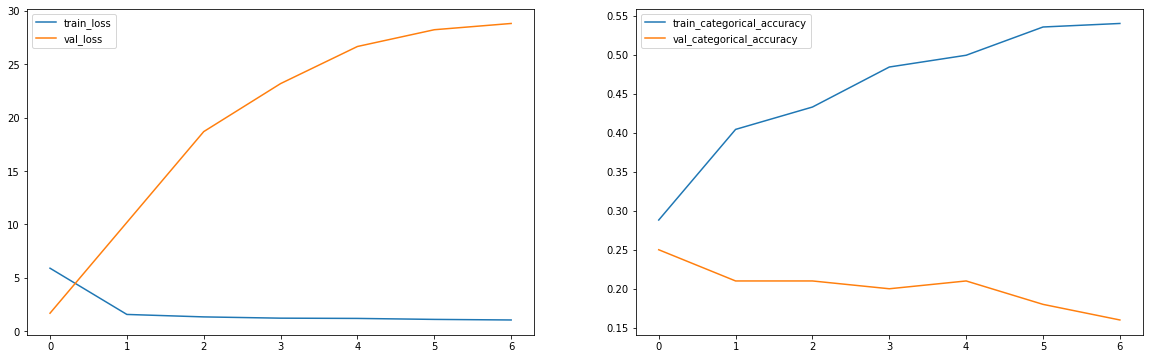

In [17]:
visualize_performance(model_conv3d_1)

#### Observation 
 - Model performance is very poor
 - Reduce number of neurons in Dense layer and increase drop out to 0.4

## Model_conv3d_2 - Reducing Params
 - Batch size 30, epochs 25
 - Conv layer with 16,32,64 neurons  & Dense Layer with 32,16 neurons
 - Filter size (2,2,2)
 - Dropout 0.4 at Dense Layers
 - Imgs in one datapoint = 24

In [76]:
class Model_conv3d_2(ModelSkeleton):
  def set_model_architecture(self, filter_size, drop_out, nuerons_in_dense_layer_1, nuerons_in_dense_layer_2):
    model = Sequential()
    model.add(Conv3D(16,filter_size, padding='same',input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(32,filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Conv3D(64,filter_size, padding='same'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling3D(pool_size=(2,2,2)))

    model.add(Flatten())
    model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(nuerons_in_dense_layer_2,activation='relu'))
    model.add(Dropout(drop_out))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])
    
    return model

In [79]:
obj_conv3d_2 = Model_conv3d_2()
obj_conv3d_2.init_img_props(img_height=100,img_width=100,isAugmentData=True)
obj_conv3d_2.init_hyper_params(epochs = 25, batch_size = 30, imgs_to_feed_in_one_data_pnt = 24)
set_model_conv3d_2_architecture = obj_conv3d_2.set_model_architecture(
    filter_size=(2,2,2), 
    drop_out = 0.4, 
    nuerons_in_dense_layer_1 = 32,
    nuerons_in_dense_layer_2 = 16)
print(set_model_conv3d_2_architecture.summary())

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_6 (Conv3D)           (None, 24, 100, 100, 16)  400       
                                                                 
 activation_6 (Activation)   (None, 24, 100, 100, 16)  0         
                                                                 
 batch_normalization_20 (Bat  (None, 24, 100, 100, 16)  64       
 chNormalization)                                                
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 12, 50, 50, 16)   0         
 3D)                                                             
                                                                 
 conv3d_7 (Conv3D)           (None, 12, 50, 50, 32)    4128      
                                                                 
 activation_7 (Activation)   (None, 12, 50, 50, 32)  

In [16]:
model_conv3d_2 = obj_conv3d_2.train_model(set_model_conv3d_2_architecture)

Epoch 1/25


2022-06-15 06:43:27.872856: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


23/23 [==============================] - ETA: 0s - loss: 2.4445 - categorical_accuracy: 0.2172
Epoch 00001: val_loss improved from inf to 5.13677, saving model to model_2022-06-1506_43_21.959265/model-00001-2.44445-0.21719-5.13677-0.19000.h5
23/23 [==============================] - 105s 5s/step - loss: 2.4445 - categorical_accuracy: 0.2172 - val_loss: 5.1368 - val_categorical_accuracy: 0.1900 - lr: 0.0010
Epoch 2/25
23/23 [==============================] - ETA: 0s - loss: 1.6111 - categorical_accuracy: 0.1931
Epoch 00002: val_loss did not improve from 5.13677
23/23 [==============================] - 104s 5s/step - loss: 1.6111 - categorical_accuracy: 0.1931 - val_loss: 16.8377 - val_categorical_accuracy: 0.1100 - lr: 0.0010
Epoch 3/25
23/23 [==============================] - ETA: 0s - loss: 1.6091 - categorical_accuracy: 0.1998
Epoch 00003: val_loss did not improve from 5.13677
23/23 [==============================] - 103s 5s/step - loss: 1.6091 - categorical_accuracy: 0.1998 - val_los

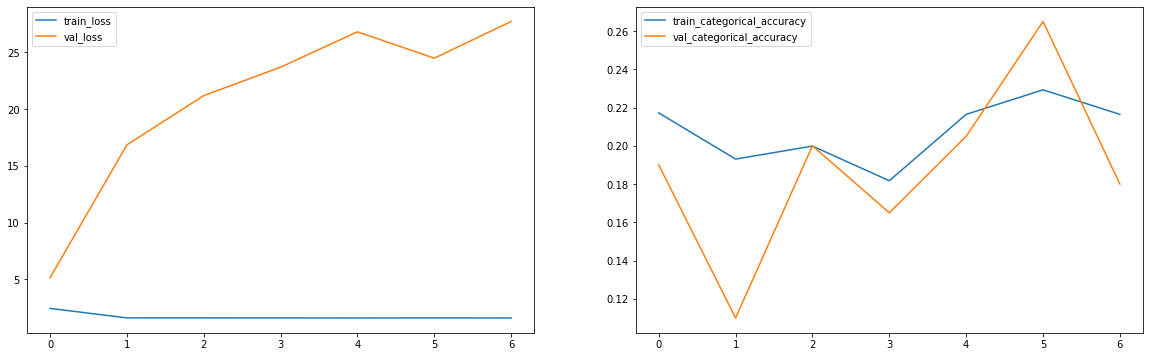

In [17]:
visualize_performance(model_conv3d_2)

#### Observation 
 - Model performance is very poor
 - Let’s switch to CNN + RNN

## Model_conv2d_lstm_4
 - Batch size 10, epochs 25
 - Conv2d with 8 & 16 units, ConvLSTM2D layer with 8 units  & Dense Layer with 64 neurons
 - Imgs in one datapoint = 30

In [16]:
class Model_conv2d_lstm_4(ModelSkeleton):
    def set_model_architecture(self):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
        model.add(BatchNormalization())
        model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
        model.add(BatchNormalization())
        model.add(TimeDistributed(Dense(64, activation='relu')))
        model.add(BatchNormalization())
        model.add(GlobalAveragePooling2D())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(5, activation='softmax'))

        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

        return model

In [19]:
obj_conv2d_lstm_4 = Model_conv2d_lstm_9()
obj_conv2d_lstm_4.init_img_props(img_height=100,img_width=100,isAugmentData=True)
obj_conv2d_lstm_4.init_hyper_params(epochs = 25, batch_size = 15, imgs_to_feed_in_one_data_pnt = 30)
set_model_conv2d_lstm_4_architecture = obj_conv2d_lstm_4.set_model_architecture()

print(set_model_conv2d_lstm_4_architecture.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_3 (TimeDis  (None, 30, 98, 98, 8)    224       
 tributed)                                                       
                                                                 
 batch_normalization_4 (Batc  (None, 30, 98, 98, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 96, 96, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 30, 96, 96, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 94, 94, 8)        

In [20]:
model_conv2d_lstm_4 = obj_conv2d_lstm_4.train_model(set_model_conv2d_lstm_4_architecture)

Epoch 1/25
45/45 [==============================] - ETA: 0s - loss: 1.4823 - categorical_accuracy: 0.3379
Epoch 00001: val_loss improved from inf to 1.60870, saving model to model_2022-06-1416_30_34.123730/model-00001-1.48234-0.33786-1.60870-0.21500.h5
45/45 [==============================] - 118s 3s/step - loss: 1.4823 - categorical_accuracy: 0.3379 - val_loss: 1.6087 - val_categorical_accuracy: 0.2150 - lr: 0.0010
Epoch 2/25
45/45 [==============================] - ETA: 0s - loss: 1.2929 - categorical_accuracy: 0.4570
Epoch 00002: val_loss did not improve from 1.60870
45/45 [==============================] - 117s 3s/step - loss: 1.2929 - categorical_accuracy: 0.4570 - val_loss: 1.6137 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 3/25
45/45 [==============================] - ETA: 0s - loss: 1.1854 - categorical_accuracy: 0.4864
Epoch 00003: val_loss did not improve from 1.60870
45/45 [==============================] - 115s 3s/step - loss: 1.1854 - categorical_accuracy: 0.4864

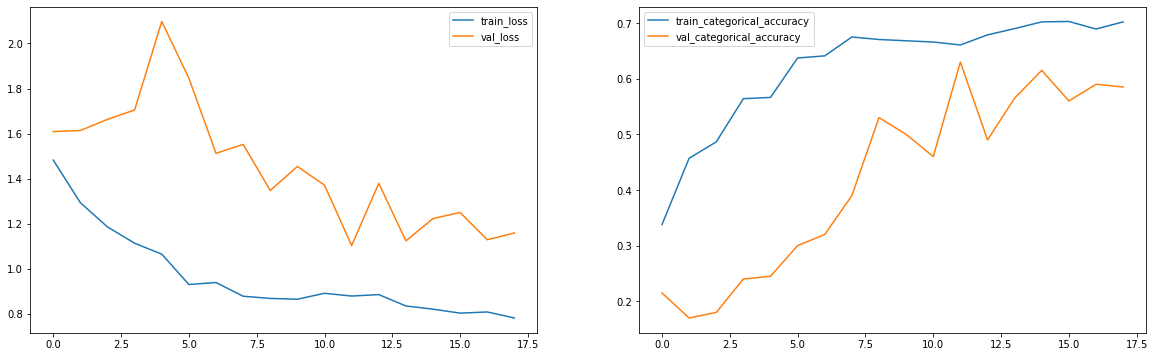

In [21]:
visualize_performance(model_conv2d_lstm_4)

#### Observation 
 - Accuracy of the model has improved
 - Let’s add more neurons/ units in layers as training accuracy is lower

## Model_conv2d_gru_5
 - Batch size 15, epochs 25
 - Conv2d with 32,32,64 & 128 units, GRU layer with 128 units  & Dense Layer with 128 neurons
 - Drop out in all layer 0.4
 - Imgs in one datapoint = 30

In [24]:
class Model_conv2d_gru_5(ModelSkeleton):
    def set_model_architecture(self, drop_out_conv,drop_out_gru, drop_out_dense, gru_cells, nuerons_in_dense_layer_1):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu'), input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
        model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(Dropout(drop_out_conv))
        
        model.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(Dropout(drop_out_conv))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out_gru))
        
        model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
        model.add(Dropout(drop_out_dense))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

        return model

In [25]:
obj_conv2d_gru_5 = Model_conv2d_gru_5()
obj_conv2d_gru_5.init_img_props(img_height=100,img_width=100,isAugmentData=True)
obj_conv2d_gru_5.init_hyper_params(epochs = 30, batch_size = 15, imgs_to_feed_in_one_data_pnt = 30)
set_model_conv2d_gru_5_architecture = obj_conv2d_gru_5.set_model_architecture(
    drop_out_conv = 0.25,
    drop_out_gru = 0.25,
    drop_out_dense = 0.25, 
    gru_cells =128,
    nuerons_in_dense_layer_1 = 128)

print(set_model_conv2d_gru_5_architecture.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_6 (TimeDis  (None, 30, 100, 100, 32)  896      
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 30, 100, 100, 32)  9248     
 tributed)                                                       
                                                                 
 time_distributed_8 (TimeDis  (None, 30, 50, 50, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_9 (TimeDis  (None, 30, 50, 50, 64)   18496     
 tributed)                                                       
                                                                 
 time_distributed_10 (TimeDi  (None, 30, 25, 25, 64)  

In [26]:
model_conv2d_gru_5 = obj_conv2d_gru_5.train_model(set_model_conv2d_gru_5_architecture)

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 1.6590 - categorical_accuracy: 0.2006
Epoch 00001: val_loss improved from inf to 1.54059, saving model to model_2022-06-1417_13_02.840795/model-00001-1.65899-0.20060-1.54059-0.23500.h5
45/45 [==============================] - 125s 3s/step - loss: 1.6590 - categorical_accuracy: 0.2006 - val_loss: 1.5406 - val_categorical_accuracy: 0.2350 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.5769 - categorical_accuracy: 0.2775
Epoch 00002: val_loss improved from 1.54059 to 1.52216, saving model to model_2022-06-1417_13_02.840795/model-00002-1.57686-0.27753-1.52216-0.38000.h5
45/45 [==============================] - 121s 3s/step - loss: 1.5769 - categorical_accuracy: 0.2775 - val_loss: 1.5222 - val_categorical_accuracy: 0.3800 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.5218 - categorical_accuracy: 0.3130
Epoch 00003: val_loss improved from 1.52216 to 1.4

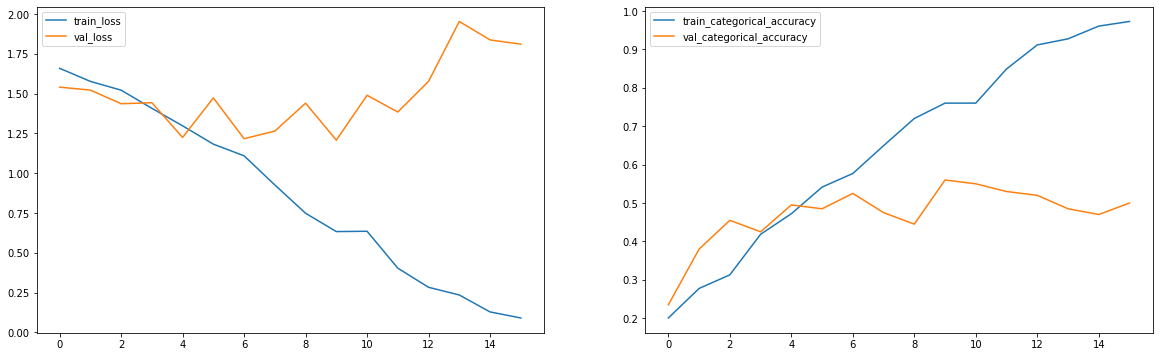

In [27]:
visualize_performance(model_conv2d_gru_5)

#### Observation 
- Clear sign of overfitting
- Let’s reduce neurones in Dense layer and include BatchNormalization in Conv layer


## Model_conv2d_gru_6
 - Batch size 15, epochs 25
 - Conv2d with 32,32,64 & 128 units, GRU layer with 128 units  & Dense Layer with 64 neurons(reduced)
 -Drop out for conv layer is 0.3 & for Dense Layer 0.4 (increased)
 - BatchNormalization in Conv layers
 - Imgs in one datapoint = 30

In [12]:
class Model_conv2d_gru_6(ModelSkeleton):
    def set_model_architecture(self, drop_out_conv, drop_out_dense, gru_cells, nuerons_in_dense_layer_1):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu'), input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
        model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
        model.add(BatchNormalization())
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        
        model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
        model.add(BatchNormalization())
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(Dropout(drop_out_conv))
        
        model.add(TimeDistributed(Conv2D(128, (3,3),padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(Dropout(drop_out_conv))

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        
        model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
        model.add(Dropout(drop_out_dense))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

        return model

In [13]:
obj_conv2d_gru_6 = Model_conv2d_gru_6()
obj_conv2d_gru_6.init_img_props(img_height=100,img_width=100,isAugmentData=True)
obj_conv2d_gru_6.init_hyper_params(epochs = 30, batch_size = 15, imgs_to_feed_in_one_data_pnt = 26)
set_model_conv2d_gru_6_architecture = obj_conv2d_gru_6.set_model_architecture(
    drop_out_conv = 0.3,
    drop_out_dense = 0.4, 
    gru_cells =128,
    nuerons_in_dense_layer_1 = 64)

print(set_model_conv2d_gru_6_architecture.summary())

2022-06-15 02:40:15.436644: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-06-15 02:40:15.436716: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14803 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 26, 100, 100, 32)  896      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 26, 100, 100, 32)  9248     
 tributed)                                                       
                                                                 
 batch_normalization (BatchN  (None, 26, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 time_distributed_2 (TimeDis  (None, 26, 50, 50, 32)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 26, 50, 50, 64)   1

In [14]:
model_conv2d_gru_6 = obj_conv2d_gru_6.train_model(set_model_conv2d_gru_6_architecture)

Epoch 1/30


2022-06-15 02:40:23.410307: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


45/45 [==============================] - ETA: 0s - loss: 1.7088 - categorical_accuracy: 0.2202
Epoch 00001: val_loss improved from inf to 1.59717, saving model to model_2022-06-1502_40_18.459908/model-00001-1.70877-0.22021-1.59717-0.22000.h5
45/45 [==============================] - 100s 2s/step - loss: 1.7088 - categorical_accuracy: 0.2202 - val_loss: 1.5972 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.6190 - categorical_accuracy: 0.2097
Epoch 00002: val_loss improved from 1.59717 to 1.57634, saving model to model_2022-06-1502_40_18.459908/model-00002-1.61895-0.20965-1.57634-0.32000.h5
45/45 [==============================] - 94s 2s/step - loss: 1.6190 - categorical_accuracy: 0.2097 - val_loss: 1.5763 - val_categorical_accuracy: 0.3200 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.5992 - categorical_accuracy: 0.2398
Epoch 00003: val_loss did not improve from 1.57634
45/45 [====

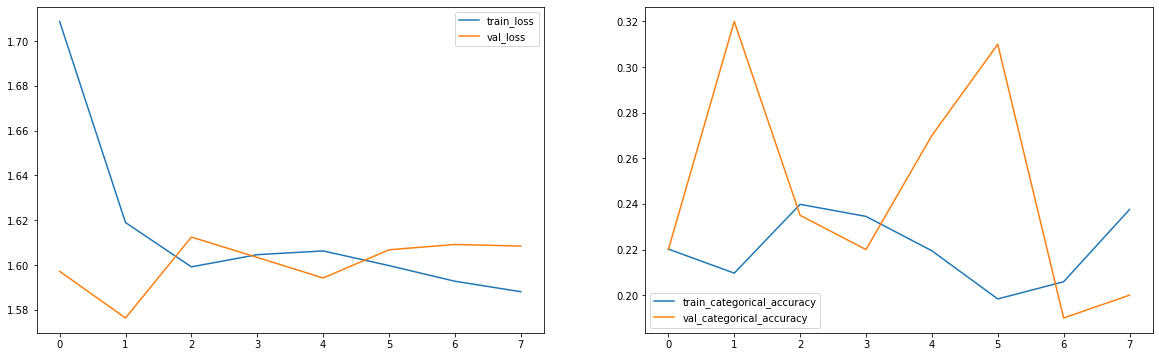

In [15]:
visualize_performance(model_conv2d_gru_6)

#### Observation 
- Poor Accuracy is observed
- Spikes in categorical validation



## Model_conv2d_gru_7
 - Batch size 15, epochs 25
 - Conv2d with 16,32,64units, GRU layer with 64 units  & Dense Layer with 64 neurons
 - Imgs in one datapoint = 26

In [19]:
class Model_conv2d_gru_7(ModelSkeleton):
    def set_model_architecture(self, drop_out_conv, drop_out_dense, gru_cells, nuerons_in_dense_layer_1):
        model = Sequential()
        model.add(TimeDistributed(Conv2D(16, (3,3),padding='same', activation='relu'), input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        
        model.add(TimeDistributed(Conv2D(32, (3,3),padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(Dropout(drop_out_conv))

        model.add(TimeDistributed(Conv2D(64, (3,3),padding='same', activation='relu')))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(Dropout(drop_out_conv))
        

        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        
        model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
        model.add(Dropout(drop_out_dense))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

        return model

In [20]:
obj_conv2d_gru_7 = Model_conv2d_gru_7()
obj_conv2d_gru_7.init_img_props(img_height=100,img_width=100,isAugmentData=True)
obj_conv2d_gru_7.init_hyper_params(epochs = 30, batch_size = 15, imgs_to_feed_in_one_data_pnt = 26)
set_model_conv2d_gru_7_architecture = obj_conv2d_gru_7.set_model_architecture(
    drop_out_conv = 0.4,
    drop_out_dense = 0.4, 
    gru_cells = 64,
    nuerons_in_dense_layer_1 = 64)

print(set_model_conv2d_gru_7_architecture.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_14 (TimeDi  (None, 26, 100, 100, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_15 (TimeDi  (None, 26, 50, 50, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_16 (TimeDi  (None, 26, 50, 50, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 26, 25, 25, 32)   0         
 stributed)                                                      
                                                                 
 dropout_5 (Dropout)         (None, 26, 25, 25, 32)   

In [21]:
model_conv2d_gru_7 = obj_conv2d_gru_7.train_model(set_model_conv2d_gru_12_architecture)

Epoch 1/30
45/45 [==============================] - ETA: 0s - loss: 1.6369 - categorical_accuracy: 0.2044
Epoch 00001: val_loss improved from inf to 1.57384, saving model to model_2022-06-1503_04_37.534799/model-00001-1.63694-0.20437-1.57384-0.25500.h5
45/45 [==============================] - 107s 2s/step - loss: 1.6369 - categorical_accuracy: 0.2044 - val_loss: 1.5738 - val_categorical_accuracy: 0.2550 - lr: 0.0010
Epoch 2/30
45/45 [==============================] - ETA: 0s - loss: 1.4968 - categorical_accuracy: 0.3424
Epoch 00002: val_loss improved from 1.57384 to 1.46124, saving model to model_2022-06-1503_04_37.534799/model-00002-1.49680-0.34238-1.46124-0.30000.h5
45/45 [==============================] - 106s 2s/step - loss: 1.4968 - categorical_accuracy: 0.3424 - val_loss: 1.4612 - val_categorical_accuracy: 0.3000 - lr: 0.0010
Epoch 3/30
45/45 [==============================] - ETA: 0s - loss: 1.3765 - categorical_accuracy: 0.4351
Epoch 00003: val_loss did not improve from 1.46124

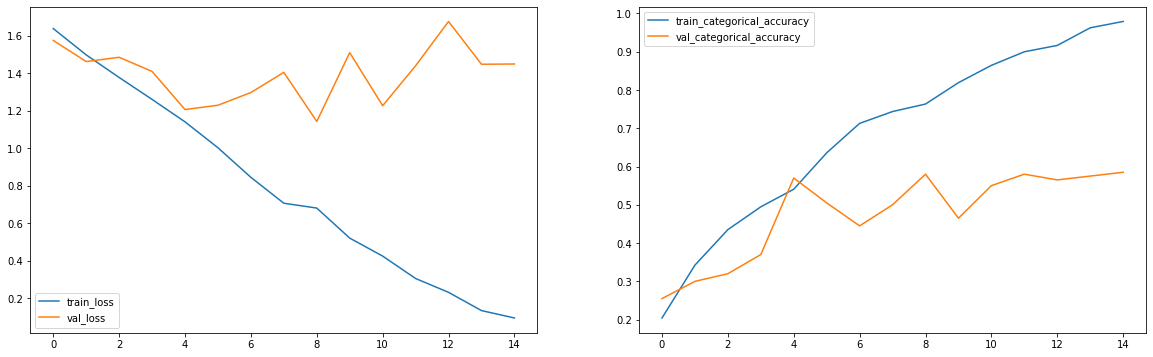

In [22]:
visualize_performance(model_conv2d_gru_7)

#### Observation 
- Clear sign of overfitting
- Let’s introduce MobileNet with LSTM


## Model_mobilenet_lstm_8
 - No augmentation
 - Batch size 20, epochs 25
 - MobileNet, LSTM layer with 128 units  & Dense Layer with 128 neurons
 - Filter size (2,2)
 - Dropout 0.25 at Conv Layers&  Dense Layers
 - Imgs in one datapoint = 26

In [25]:
from keras.applications import mobilenet

In [26]:
mobilenet_model = mobilenet.MobileNet(weights='imagenet', include_top=False)

17235968/17225924 [==============================] - 1s 0us/step


In [60]:
class Model_mobilenet_lstm_8(ModelSkeleton):
    def set_model_architecture(self, drop_out_lstm, drop_out_dense,lstm_cells, nuerons_in_dense_layer_1):
        model = Sequential()
        model.add(TimeDistributed(mobilenet_model,input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(TimeDistributed(Flatten()))
        
        model.add(LSTM(lstm_cells))
        model.add(Dropout(drop_out_lstm))

        model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
        model.add(Dropout(drop_out_dense))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

        return model

In [61]:
obj_mobilenet_lstm_8 = Model_mobilenet_lstm_8()
obj_mobilenet_lstm_8.init_img_props(img_height=100,img_width=100,isAugmentData=False)
obj_mobilenet_lstm_8.init_hyper_params(epochs = 25, batch_size = 5, imgs_to_feed_in_one_data_pnt = 26)
set_model_mobilenet_lstm_8_architecture = obj_mobilenet_lstm_8.set_model_architecture(
    drop_out_lstm = 0.25,
    drop_out_dense = 0.25, 
    lstm_cells =128,
    nuerons_in_dense_layer_1 = 128)

print(set_model_mobilenet_lstm_8_architecture.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_44 (TimeDi  (None, 26, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_45 (TimeDi  (None, 26, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_46 (TimeDi  (None, 26, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_47 (TimeDi  (None, 26, 1024)         0         
 stributed)                                                      
                                                                 
 lstm_11 (LSTM)              (None, 128)             

In [62]:
model_mobilenet_lstm_8 = obj_mobilenet_lstm_8.train_model(set_model_mobilenet_lstm_8_architecture)

Epoch 1/25
133/133 [==============================] - ETA: 0s - loss: 1.4486 - categorical_accuracy: 0.3680
Epoch 00001: val_loss improved from inf to 1.16287, saving model to model_2022-06-1219_19_02.284146/model-00001-1.44865-0.36802-1.16287-0.50000.h5
133/133 [==============================] - 56s 399ms/step - loss: 1.4486 - categorical_accuracy: 0.3680 - val_loss: 1.1629 - val_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 2/25
133/133 [==============================] - ETA: 0s - loss: 0.9687 - categorical_accuracy: 0.6259
Epoch 00002: val_loss improved from 1.16287 to 1.00917, saving model to model_2022-06-1219_19_02.284146/model-00002-0.96874-0.62594-1.00917-0.56000.h5
133/133 [==============================] - 52s 390ms/step - loss: 0.9687 - categorical_accuracy: 0.6259 - val_loss: 1.0092 - val_categorical_accuracy: 0.5600 - lr: 0.0010
Epoch 3/25
133/133 [==============================] - ETA: 0s - loss: 0.7340 - categorical_accuracy: 0.7179
Epoch 00003: val_loss improved from 

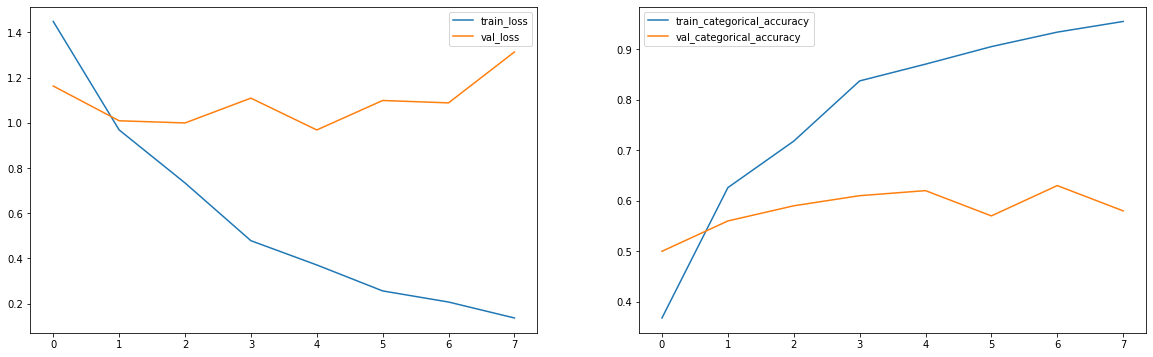

In [63]:
visualize_performance(model_mobilenet_lstm_8)

#### Observation 
- Clear sign of overfitting
- Number of parameters are high, let’s try GRU with reduced units in GRU layer

## Model_mobilenet_gru_9
 - Batch size 10, epochs 25
 - MobileNet, GRU layer with 64 units  & Dense Layer with 64 neurons
 - Dropout 0.25 at Conv Layers&  Dense Layers
 - Imgs in one datapoint = 26

In [144]:
class Model_mobilenet_gru_9(ModelSkeleton):
    def set_model_architecture(self, drop_out_gru, drop_out_dense,gru_cells, nuerons_in_dense_layer_1):
        model = Sequential()
        model.add(TimeDistributed(mobilenet_model,input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
        
        for layer in model.layers:
            layer.trainable = False
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out_gru))

        model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
        model.add(Dropout(drop_out_dense))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

        return model

In [147]:
obj_mobilenet_gru_9 = Model_mobilenet_gru_9()
obj_mobilenet_gru_9.init_img_props(img_height=100,img_width=100,isAugmentData=True)
obj_mobilenet_gru_9.init_hyper_params(epochs = 25, batch_size = 10, imgs_to_feed_in_one_data_pnt = 26)
set_model_mobilenet_gru_9_architecture = obj_mobilenet_gru_9.set_model_architecture(
    drop_out_gru = 0.25,
    drop_out_dense = 0.25, 
    gru_cells =64,
    nuerons_in_dense_layer_1 = 64)

print(set_model_mobilenet_gru_9_architecture.summary())

Model: "sequential_37"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_200 (TimeD  (None, 26, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_201 (TimeD  (None, 26, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_202 (TimeD  (None, 26, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_203 (TimeD  (None, 26, 1024)         0         
 istributed)                                                     
                                                                 
 gru_7 (GRU)                 (None, 64)              

In [148]:
model_mobilenet_gru_9 = obj_mobilenet_gru_9.train_model(set_model_mobilenet_gru_9_architecture)

Epoch 1/25
67/67 [==============================] - ETA: 0s - loss: 1.5172 - categorical_accuracy: 0.3537
Epoch 00001: val_loss improved from inf to 1.13977, saving model to model_2022-06-1220_54_00.816807/model-00001-1.51718-0.35370-1.13977-0.58500.h5
67/67 [==============================] - 111s 2s/step - loss: 1.5172 - categorical_accuracy: 0.3537 - val_loss: 1.1398 - val_categorical_accuracy: 0.5850 - lr: 0.0010
Epoch 2/25
67/67 [==============================] - ETA: 0s - loss: 0.9721 - categorical_accuracy: 0.6380
Epoch 00002: val_loss improved from 1.13977 to 0.94313, saving model to model_2022-06-1220_54_00.816807/model-00002-0.97212-0.63801-0.94313-0.59000.h5
67/67 [==============================] - 106s 2s/step - loss: 0.9721 - categorical_accuracy: 0.6380 - val_loss: 0.9431 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/25
67/67 [==============================] - ETA: 0s - loss: 0.6843 - categorical_accuracy: 0.7594
Epoch 00003: val_loss improved from 0.94313 to 0.9

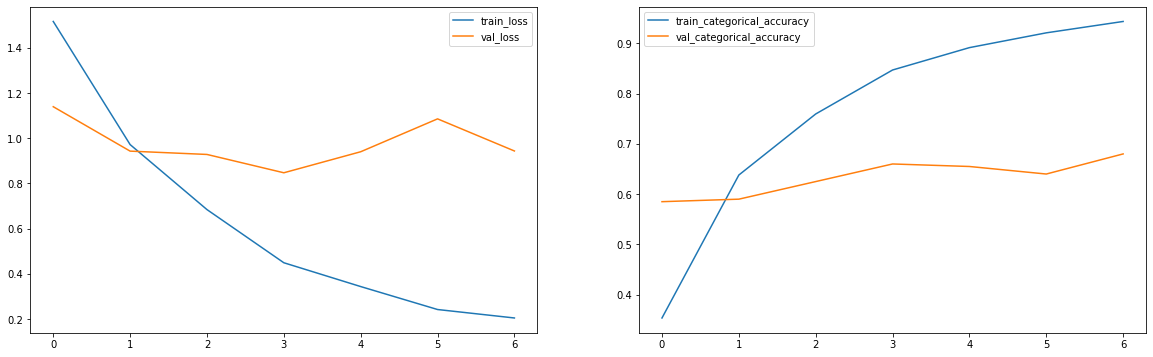

In [149]:
visualize_performance(model_mobilenet_gru_9)

#### Observation 
- Overfitting is reduced by some fraction but still it is to be addressed
- We are going to train MobileNet weights as we have less train data


## Model_mobilenet_gru_10
 - Train all weights
 - Batch size 10, epochs 30
 - MobileNet, GRU layer with 32 units  & Dense Layer with 32 neurons
 - Dropout 0.3 at Conv Layers &  0.4 at Dense Layers
 - Imgs in one datapoint = 26

In [23]:
class Model_mobilenet_gru_10(ModelSkeleton):
    def set_model_architecture(self, drop_out_gru, drop_out_dense,gru_cells, nuerons_in_dense_layer_1):
        model = Sequential()
        model.add(TimeDistributed(mobilenet_model,input_shape=(self.imgs_to_feed_in_one_data_pnt,self.img_height,self.img_width,3)))
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D(pool_size=(2,2))))
        model.add(TimeDistributed(Flatten()))
        
        model.add(GRU(gru_cells))
        model.add(Dropout(drop_out_gru))

        model.add(Dense(nuerons_in_dense_layer_1,activation='relu'))
        model.add(Dropout(drop_out_dense))

        model.add(Dense(num_classes, activation='softmax'))

        model.compile(optimizer = 'adam', loss='categorical_crossentropy', metrics = ['categorical_accuracy'])

        return model

In [28]:
obj_mobilenet_gru_10 = Model_mobilenet_gru_10()
obj_mobilenet_gru_10.init_img_props(img_height=120,img_width=120,isAugmentData=True)
obj_mobilenet_gru_10.init_hyper_params(epochs =30, batch_size = 5, imgs_to_feed_in_one_data_pnt = 20)
set_model_mobilenet_gru_10_architecture = obj_mobilenet_gru_10.set_model_architecture(
    drop_out_gru = 0.3,
    drop_out_dense = 0.3, 
    gru_cells =128,
    nuerons_in_dense_layer_1 = 128)

print(set_model_mobilenet_gru_10_architecture.summary())


Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_25 (TimeDi  (None, 20, 3, 3, 1024)   3228864   
 stributed)                                                      
                                                                 
 time_distributed_26 (TimeDi  (None, 20, 3, 3, 1024)   4096      
 stributed)                                                      
                                                                 
 time_distributed_27 (TimeDi  (None, 20, 1, 1, 1024)   0         
 stributed)                                                      
                                                                 
 time_distributed_28 (TimeDi  (None, 20, 1024)         0         
 stributed)                                                      
                                                                 
 gru_4 (GRU)                 (None, 128)              

In [29]:
model_mobilenet_gru_10 = obj_mobilenet_gru_10.train_model(set_model_mobilenet_gru_10_architecture)

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 1.2571 - categorical_accuracy: 0.4887
Epoch 00001: val_loss improved from inf to 1.12474, saving model to model_2022-06-1503_42_28.535301/model-00001-1.25713-0.48869-1.12474-0.51000.h5
133/133 [==============================] - 102s 729ms/step - loss: 1.2571 - categorical_accuracy: 0.4887 - val_loss: 1.1247 - val_categorical_accuracy: 0.5100 - lr: 0.0010
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.8816 - categorical_accuracy: 0.6637
Epoch 00002: val_loss improved from 1.12474 to 0.96171, saving model to model_2022-06-1503_42_28.535301/model-00002-0.88157-0.66365-0.96171-0.59000.h5
133/133 [==============================] - 98s 744ms/step - loss: 0.8816 - categorical_accuracy: 0.6637 - val_loss: 0.9617 - val_categorical_accuracy: 0.5900 - lr: 0.0010
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.7690 - categorical_accuracy: 0.7210
Epoch 00003: val_loss did not impro

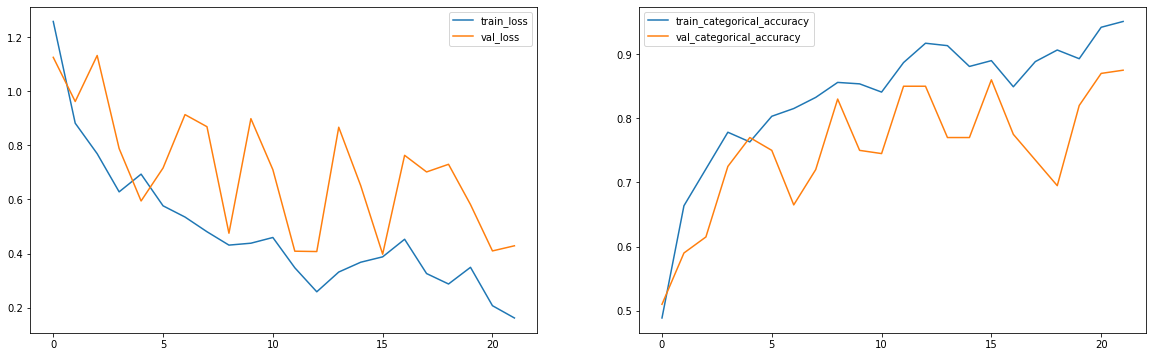

In [30]:
visualize_performance(model_mobilenet_gru_10)

#### Observation 
- Overfitting is reduced 
- We are chosing this model as the Final Model 